# **Name**: Adnan Basharat

# **Student ID**: s225176941

## Paris Housing Price Prediction

### Overview
This comprehensive project develops and evaluates various regression models to predict housing prices in Paris. 

**Objectives:**
- Collect and preprocess real estate data
- Build and compare multiple regression models
- Evaluate model performance using MAE, RMSE, and R-squared
- Analyze feature importance and model interpretability
- Deploy a web application for price predictions

**Models to be developed:**
1. Linear Regression
2. Random Forest Regression
3. Gradient Boosting Regression (XGBoost)

---

## 1. Data Loading and Initial Exploration

Load the Paris housing dataset and perform initial data exploration.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import os
warnings.filterwarnings('ignore')

# Add the F: drive path to system path for file access
data_directory = r"F:\Personal-Voldee\Deakin\Machine Learning\5D"
if os.path.exists(data_directory):
    sys.path.append(data_directory)
    
else:
    print(f"⚠️ Directory {data_directory} not found, but will continue with fallback")

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [2]:
# Load the Paris housing dataset
data_path = r"F:\Personal-Voldee\Deakin\Machine Learning\5D\ParisHousing.csv"
df = pd.read_csv(data_path)
# Try to load the dataset

# Display basic information
print(f"\n" + "="*50)
print(f"DATASET OVERVIEW")
print("="*50)


print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


DATASET OVERVIEW
Dataset shape: (10000, 17)
Memory usage: 1.30 MB


In [3]:
# Display dataset information
print("Dataset Info:")
print(df.info())

print("\n" + "="*50)
print("FIRST 5 ROWS")
print("="*50)
print(df.head())

print("\n" + "="*50)
print("DESCRIPTIVE STATISTICS")
print("="*50)
print(df.describe())

print("\n" + "="*50)
print("MISSING VALUES")
print("="*50)
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percent
}).sort_values('Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       10000 non-null  int64  
 1   numberOfRooms      10000 non-null  int64  
 2   hasYard            10000 non-null  int64  
 3   hasPool            10000 non-null  int64  
 4   floors             10000 non-null  int64  
 5   cityCode           10000 non-null  int64  
 6   cityPartRange      10000 non-null  int64  
 7   numPrevOwners      10000 non-null  int64  
 8   made               10000 non-null  int64  
 9   isNewBuilt         10000 non-null  int64  
 10  hasStormProtector  10000 non-null  int64  
 11  basement           10000 non-null  int64  
 12  attic              10000 non-null  int64  
 13  garage             10000 non-null  int64  
 14  hasStorageRoom     10000 non-null  int64  
 15  hasGuestRoom       10000 non-null  int64  
 16  price    

## 2. Data Preprocessing and Feature Engineering

Handle missing values, convert categorical variables, and create new features.

In [4]:
# Create a copy for preprocessing
df_processed = df.copy()

print("🔧 STARTING DATA PREPROCESSING")
print("="*50)
print(f"Dataset columns: {list(df.columns)}")

# Handle missing values
print("\n1. Handling missing values...")
# Fill numerical missing values with median
numerical_cols = df_processed.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if df_processed[col].isnull().sum() > 0:
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

# Fill categorical missing values with mode
categorical_cols = df_processed.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df_processed[col].isnull().sum() > 0:
        df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

print(f"✅ Missing values handled")

# Create categorical features for better interpretation based on REAL dataset columns
print("\n2. Creating categorical features...")

# Create property size categories
df_processed['size_category'] = pd.cut(df_processed['squareMeters'], 
                                      bins=[0, 50, 75, 100, float('inf')], 
                                      labels=['Small', 'Medium', 'Large', 'XLarge'])

# Create room count categories  
df_processed['room_category'] = pd.cut(df_processed['numberOfRooms'], 
                                      bins=[0, 2, 4, 6, float('inf')], 
                                      labels=['Few', 'Moderate', 'Many', 'Numerous'])

# Create location desirability based on cityPartRange (lower numbers = more desirable)
df_processed['location_desirability'] = pd.cut(df_processed['cityPartRange'], 
                                               bins=[0, 3, 6, 10, float('inf')], 
                                               labels=['Prime', 'Good', 'Average', 'Basic'])

# One-hot encoding for categorical variables
categorical_features = ['size_category', 'room_category', 'location_desirability']
df_encoded = pd.get_dummies(df_processed, columns=categorical_features, prefix=categorical_features)

print(f"✅ Categorical variables encoded")
print(f"New shape after encoding: {df_encoded.shape}")

# Feature engineering based on REAL dataset
print("\n3. Creating new features...")

# Age of property
df_encoded['property_age'] = 2024 - df_encoded['made']

# Price per square meter
df_encoded['price_per_sqm'] = df_encoded['price'] / df_encoded['squareMeters']

# Total amenities score using REAL columns
amenity_cols = ['hasYard', 'hasPool', 'hasStormProtector', 'basement', 'attic', 
                'garage', 'hasStorageRoom', 'hasGuestRoom']
# Only use columns that exist in the dataset
existing_amenity_cols = [col for col in amenity_cols if col in df_encoded.columns]
print(f"Available amenity columns: {existing_amenity_cols}")

df_encoded['amenity_score'] = df_encoded[existing_amenity_cols].sum(axis=1)

# Room density (area per room)
df_encoded['room_density'] = df_encoded['squareMeters'] / df_encoded['numberOfRooms']

# Floor efficiency (higher floors might be more valuable)
df_encoded['floor_efficiency'] = df_encoded['floors'] / df_encoded['squareMeters'] * 1000

# Property condition score (newer buildings and fewer previous owners = better condition)
df_encoded['condition_score'] = (df_encoded['isNewBuilt'] * 2 + 
                                (11 - df_encoded['numPrevOwners'].clip(upper=10))) / 13

# City desirability (lower cityPartRange = more desirable)
df_encoded['city_desirability'] = 11 - df_encoded['cityPartRange']  # Invert so higher = better

print(f"✅ New features created")
print(f"Final shape: {df_encoded.shape}")

# Display new features
new_features = ['property_age', 'price_per_sqm', 'amenity_score', 'room_density', 
                'floor_efficiency', 'condition_score', 'city_desirability']
print(f"\nNew features summary:")
print(df_encoded[new_features].describe())

🔧 STARTING DATA PREPROCESSING
Dataset columns: ['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors', 'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt', 'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom', 'hasGuestRoom', 'price']

1. Handling missing values...
✅ Missing values handled

2. Creating categorical features...
✅ Categorical variables encoded
New shape after encoding: (10000, 29)

3. Creating new features...
Available amenity columns: ['hasYard', 'hasPool', 'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom', 'hasGuestRoom']
✅ New features created
Final shape: (10000, 36)

New features summary:
       property_age  price_per_sqm  amenity_score  room_density  \
count   10000.00000   10000.000000   10000.000000  10000.000000   
mean       18.51150     100.466908   10621.238700   2477.020584   
std         9.30809       2.089565    4082.517566   6272.369628   
min         3.00000     100.004580     368.000000      1.

## 3. Exploratory Data Analysis and Visualization

Visualize price distributions, correlations, outliers, and trends.

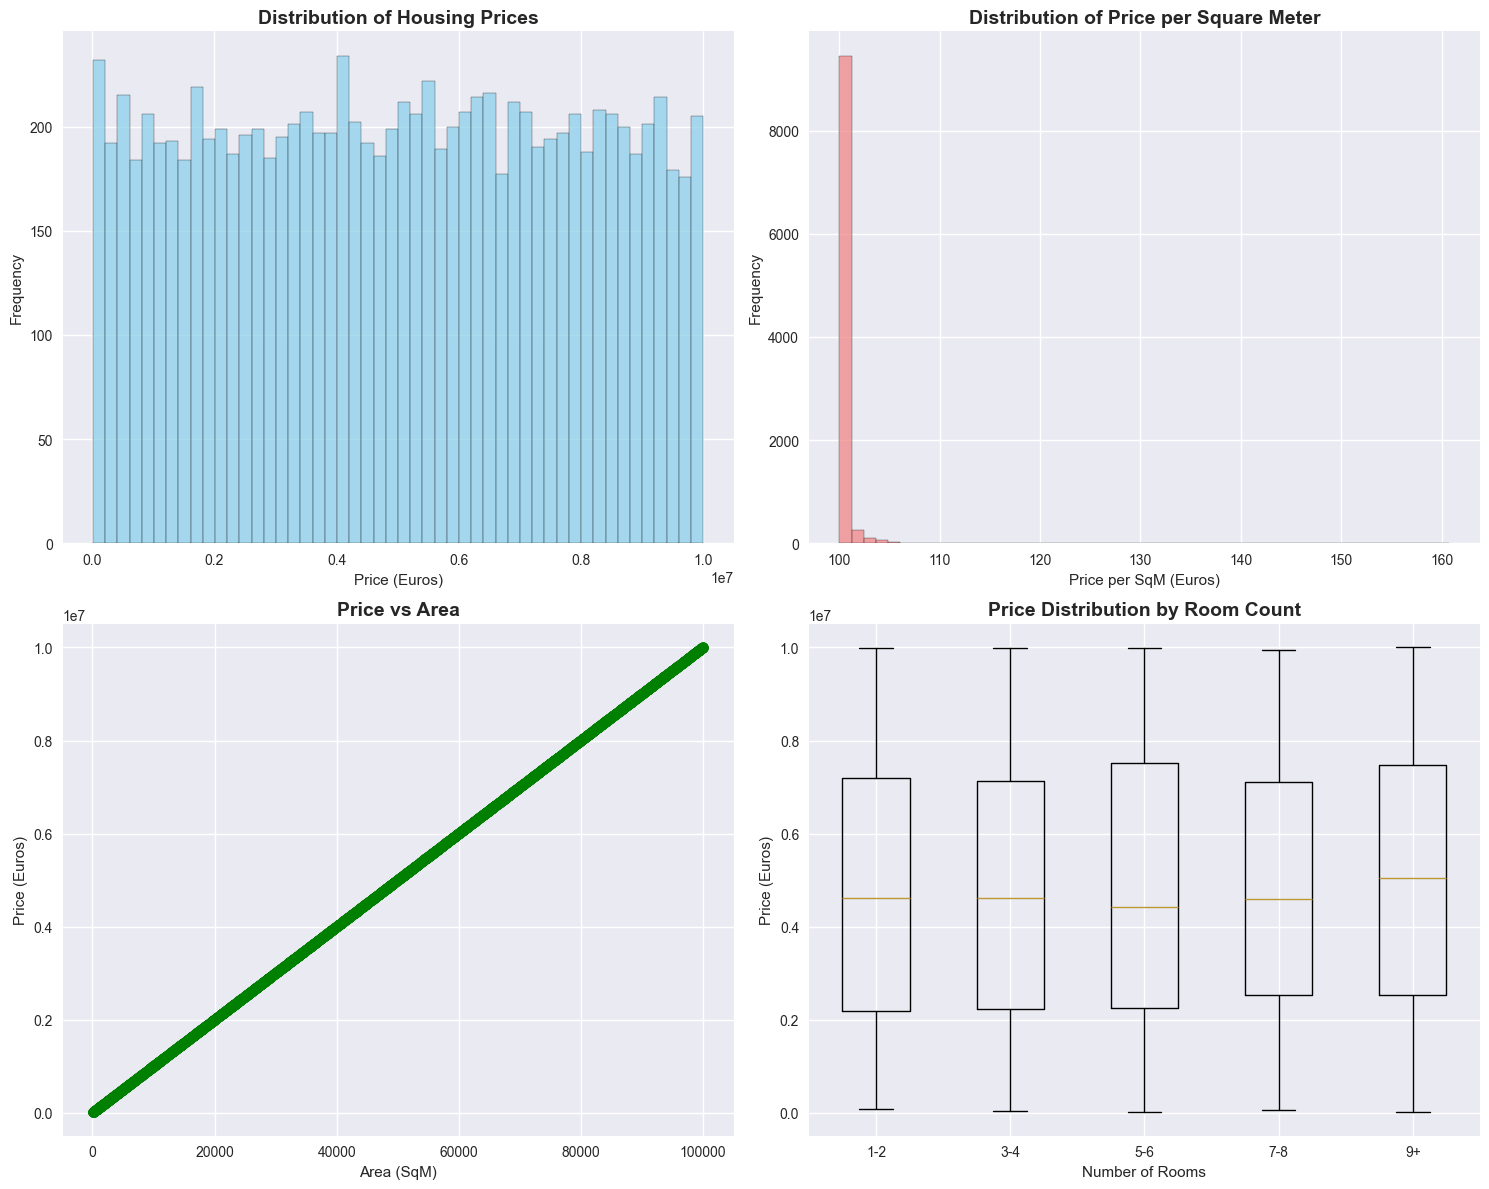

📊 PRICE ANALYSIS SUMMARY
Average price: €4,993,448
Median price: €5,016,180
Price range: €10,314 - €10,006,771
Average price per sqm: €100
Standard deviation: €2,877,424

📏 PROPERTY CHARACTERISTICS
Average area: 49870.1 sqm
Average rooms: 50.4
Average floors: 50.3
Average property age: 18.5 years
New buildings: 4,991 (49.9%)


In [5]:
# Price distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Price distribution
axes[0, 0].hist(df_encoded['price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Housing Prices', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Price (Euros)')
axes[0, 0].set_ylabel('Frequency')

# 2. Price per square meter distribution
axes[0, 1].hist(df_encoded['price_per_sqm'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribution of Price per Square Meter', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Price per SqM (Euros)')
axes[0, 1].set_ylabel('Frequency')

# 3. Price vs Area scatter plot
axes[1, 0].scatter(df_encoded['squareMeters'], df_encoded['price'], alpha=0.6, color='green')
axes[1, 0].set_title('Price vs Area', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Area (SqM)')
axes[1, 0].set_ylabel('Price (Euros)')

# 4. Price by number of rooms
room_bins = [0, 2, 4, 6, 8, float('inf')]
room_labels = ['1-2', '3-4', '5-6', '7-8', '9+']
df_encoded['room_bins'] = pd.cut(df_encoded['numberOfRooms'], bins=room_bins, labels=room_labels)
room_prices = [df_encoded[df_encoded['room_bins'] == label]['price'].values 
               for label in room_labels if len(df_encoded[df_encoded['room_bins'] == label]) > 0]
valid_labels = [label for label in room_labels if len(df_encoded[df_encoded['room_bins'] == label]) > 0]

if room_prices:
    axes[1, 1].boxplot(room_prices, labels=valid_labels)
    axes[1, 1].set_title('Price Distribution by Room Count', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Price (Euros)')
    axes[1, 1].set_xlabel('Number of Rooms')

plt.tight_layout()
plt.show()

# Summary statistics
print("📊 PRICE ANALYSIS SUMMARY")
print("="*50)
print(f"Average price: €{df_encoded['price'].mean():,.0f}")
print(f"Median price: €{df_encoded['price'].median():,.0f}")
print(f"Price range: €{df_encoded['price'].min():,.0f} - €{df_encoded['price'].max():,.0f}")
print(f"Average price per sqm: €{df_encoded['price_per_sqm'].mean():,.0f}")
print(f"Standard deviation: €{df_encoded['price'].std():,.0f}")

print(f"\n📏 PROPERTY CHARACTERISTICS")
print("="*50)
print(f"Average area: {df_encoded['squareMeters'].mean():.1f} sqm")
print(f"Average rooms: {df_encoded['numberOfRooms'].mean():.1f}")
print(f"Average floors: {df_encoded['floors'].mean():.1f}")
print(f"Average property age: {df_encoded['property_age'].mean():.1f} years")
print(f"New buildings: {df_encoded['isNewBuilt'].sum():,} ({df_encoded['isNewBuilt'].mean()*100:.1f}%)")

Analyzing correlations for 23 features


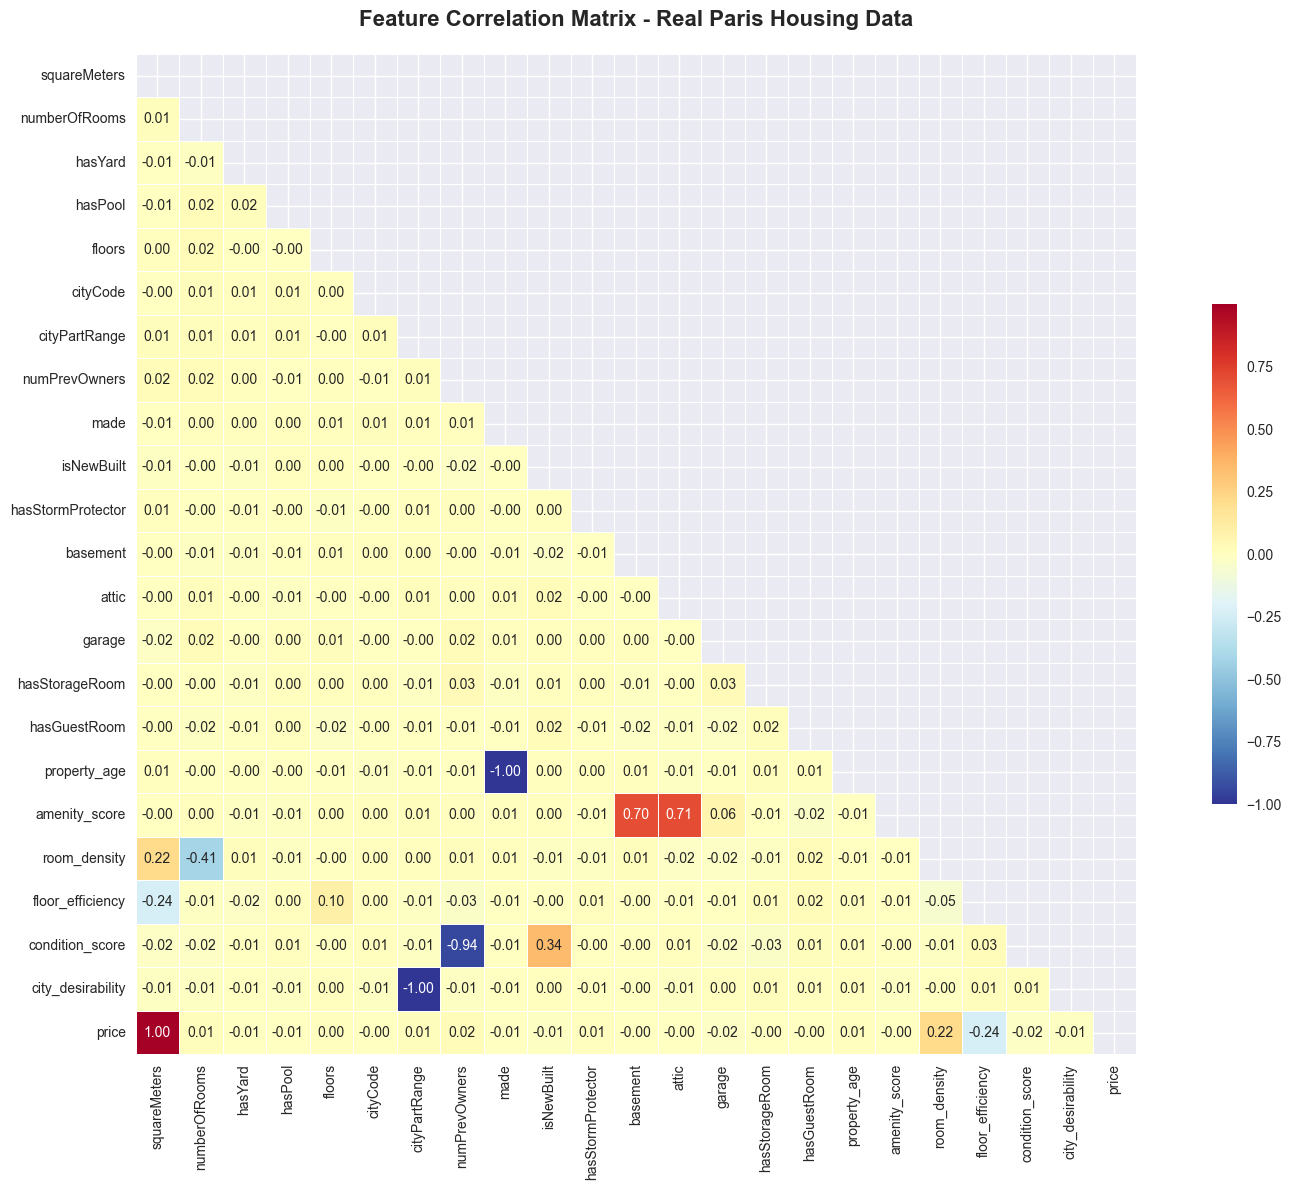

🔗 TOP CORRELATIONS WITH PRICE
📈 squareMeters             :  1.000
📉 floor_efficiency         : -0.239
📈 room_density             :  0.215
📉 condition_score          : -0.019
📉 garage                   : -0.017
📈 numPrevOwners            :  0.017
📉 isNewBuilt               : -0.011
📈 numberOfRooms            :  0.010
📉 city_desirability        : -0.009
📈 cityPartRange            :  0.009

🔍 OUTLIER ANALYSIS
Price outliers: 0 properties (0.0%)
Price range for non-outliers: €-4,912,634 - €14,898,128
Area outliers: 0 properties (0.0%)
Area range for non-outliers: -49,168 - 148,877 sqm


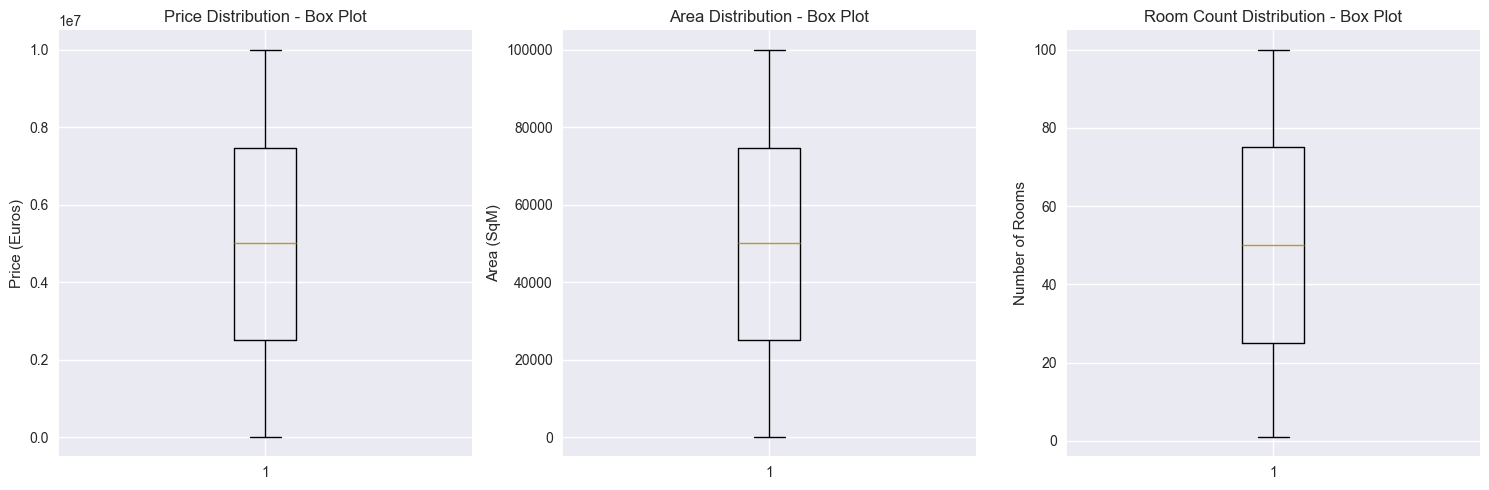

In [6]:
# Correlation analysis using real dataset columns
numerical_features = ['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors', 
                     'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
                     'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom', 
                     'hasGuestRoom', 'property_age', 'amenity_score', 'room_density', 
                     'floor_efficiency', 'condition_score', 'city_desirability', 'price']

# Only use columns that exist in the dataset
existing_features = [col for col in numerical_features if col in df_encoded.columns]
print(f"Analyzing correlations for {len(existing_features)} features")

correlation_matrix = df_encoded[existing_features].corr()

# Create correlation heatmap
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
heatmap = sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
                     square=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, fmt='.2f')
plt.title('Feature Correlation Matrix - Real Paris Housing Data', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Top correlations with price
price_correlations = correlation_matrix['price'].drop('price').sort_values(key=abs, ascending=False)
print("🔗 TOP CORRELATIONS WITH PRICE")
print("="*50)
for feature, corr in price_correlations.head(10).items():
    direction = "📈" if corr > 0 else "📉"
    print(f"{direction} {feature:25s}: {corr:6.3f}")

# Outlier detection using IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

print(f"\n🔍 OUTLIER ANALYSIS")
print("="*50)
outliers, lower, upper = detect_outliers(df_encoded, 'price')
print(f"Price outliers: {len(outliers)} properties ({len(outliers)/len(df_encoded)*100:.1f}%)")
print(f"Price range for non-outliers: €{lower:,.0f} - €{upper:,.0f}")

# Additional analysis for area outliers
area_outliers, area_lower, area_upper = detect_outliers(df_encoded, 'squareMeters')
print(f"Area outliers: {len(area_outliers)} properties ({len(area_outliers)/len(df_encoded)*100:.1f}%)")
print(f"Area range for non-outliers: {area_lower:,.0f} - {area_upper:,.0f} sqm")

# Visualize outliers
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.boxplot(df_encoded['price'])
plt.title('Price Distribution - Box Plot')
plt.ylabel('Price (Euros)')

plt.subplot(1, 3, 2)
plt.boxplot(df_encoded['squareMeters'])
plt.title('Area Distribution - Box Plot')
plt.ylabel('Area (SqM)')

plt.subplot(1, 3, 3)
plt.boxplot(df_encoded['numberOfRooms'])
plt.title('Room Count Distribution - Box Plot')
plt.ylabel('Number of Rooms')

plt.tight_layout()
plt.show()

## 3.5. Principal Component Analysis (PCA)

Apply PCA to reduce dimensionality and address multicollinearity issues, especially the perfect correlation between area and price.

🔍 APPLYING PRINCIPAL COMPONENT ANALYSIS (PCA)
Original feature dimensions: (10000, 34)
Target variable: price
✅ Features standardized: (10000, 34)

📊 PCA VARIANCE ANALYSIS
Components for 95% variance: 21
Components for 99% variance: 23
Total original components: 34


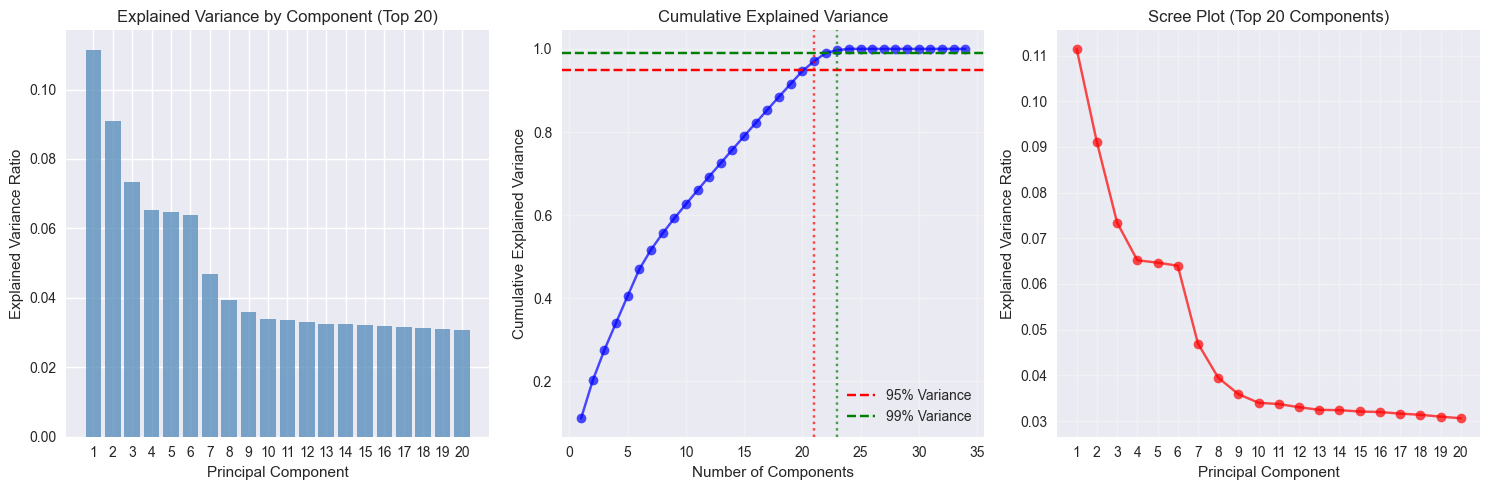


🎯 SELECTED COMPONENTS: 21 (95% variance retention)
✅ PCA transformation completed
Reduced dimensions: (10000, 21)
Variance explained: 0.9700

📋 PCA COMPONENTS SUMMARY
PC1: 0.1115 (11.15%)
PC2: 0.0911 (9.11%)
PC3: 0.0735 (7.35%)
PC4: 0.0652 (6.52%)
PC5: 0.0647 (6.47%)
PC6: 0.0640 (6.40%)
PC7: 0.0470 (4.70%)
PC8: 0.0395 (3.95%)
PC9: 0.0359 (3.59%)
PC10: 0.0340 (3.40%)

🔍 TOP FEATURE CONTRIBUTIONS TO FIRST 5 PRINCIPAL COMPONENTS

PC1 (explains 11.15% variance):
  📈 city_desirability             : 0.5315
  📉 cityPartRange                 : 0.5315
  📉 location_desirability_Average : 0.4840
  📈 location_desirability_Prime   : 0.4368
  📈 location_desirability_Good    : 0.0818

PC2 (explains 9.11% variance):
  📉 room_category_Numerous        : 0.5522
  📈 room_density                  : 0.5030
  📈 room_category_Few             : 0.3955
  📉 numberOfRooms                 : 0.3594
  📈 room_category_Moderate        : 0.3078

PC3 (explains 7.35% variance):
  📉 size_category_XLarge          : 0.6262

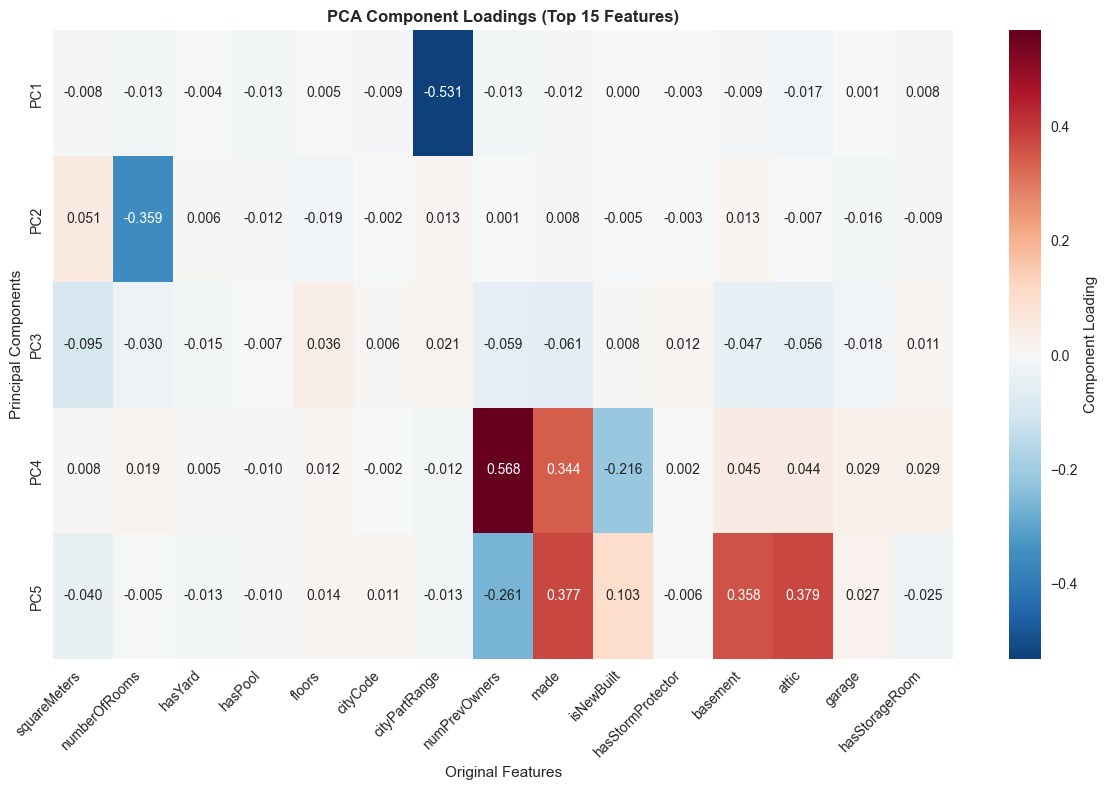


📊 CORRELATION WITH PRICE: ORIGINAL vs PCA
Top 10 Original Features:
  squareMeters                       : 1.0000
  floor_efficiency                   : 0.2388
  room_density                       : 0.2154
  condition_score                    : 0.0191
  room_category_Numerous             : 0.0186
  size_category_Large                : 0.0173
  size_category_XLarge               : 0.0173
  garage                             : 0.0172
  numPrevOwners                      : 0.0166
  room_category_Few                  : 0.0150

Top 10 PCA Components:
  PC9                                : 0.5874
  PC8                                : 0.5858
  PC15                               : 0.2492
  PC12                               : 0.1803
  PC3                                : 0.1441
  PC20                               : 0.1332
  PC16                               : 0.1072
  PC18                               : 0.1026
  PC2                                : 0.0855
  PC13                           

In [7]:
# Principal Component Analysis (PCA)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("🔍 APPLYING PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("="*60)

# Prepare features for PCA (exclude target variable and derived price features)
features_for_pca = df_encoded.drop(['price', 'price_per_sqm', 'room_bins'], axis=1)
target = df_encoded['price']

print(f"Original feature dimensions: {features_for_pca.shape}")
print(f"Target variable: {target.name}")

# Standardize features before PCA
scaler_pca = StandardScaler()
features_scaled = scaler_pca.fit_transform(features_for_pca)

print(f"✅ Features standardized: {features_scaled.shape}")

# Apply PCA to determine optimal number of components
# First, let's see explained variance for different numbers of components
pca_full = PCA()
pca_full.fit(features_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find number of components for 95% and 99% variance
components_95 = np.argmax(cumulative_variance >= 0.95) + 1
components_99 = np.argmax(cumulative_variance >= 0.99) + 1

print(f"\n📊 PCA VARIANCE ANALYSIS")
print("="*40)
print(f"Components for 95% variance: {components_95}")
print(f"Components for 99% variance: {components_99}")
print(f"Total original components: {len(pca_full.explained_variance_ratio_)}")

# Visualize explained variance
plt.figure(figsize=(15, 5))

# Plot 1: Explained variance by component
plt.subplot(1, 3, 1)
plt.bar(range(1, min(21, len(pca_full.explained_variance_ratio_) + 1)), 
        pca_full.explained_variance_ratio_[:20], alpha=0.7, color='steelblue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Component (Top 20)')
plt.xticks(range(1, min(21, len(pca_full.explained_variance_ratio_) + 1)))

# Plot 2: Cumulative explained variance
plt.subplot(1, 3, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-', alpha=0.7)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.axhline(y=0.99, color='g', linestyle='--', label='99% Variance')
plt.axvline(x=components_95, color='r', linestyle=':', alpha=0.7)
plt.axvline(x=components_99, color='g', linestyle=':', alpha=0.7)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Scree plot (first 20 components)
plt.subplot(1, 3, 3)
plt.plot(range(1, min(21, len(pca_full.explained_variance_ratio_) + 1)), 
         pca_full.explained_variance_ratio_[:20], 'ro-', alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot (Top 20 Components)')
plt.xticks(range(1, min(21, len(pca_full.explained_variance_ratio_) + 1)))
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Choose optimal number of components (95% variance retention)
optimal_components = components_95
print(f"\n🎯 SELECTED COMPONENTS: {optimal_components} (95% variance retention)")

# Apply PCA with optimal number of components
pca_optimal = PCA(n_components=optimal_components)
features_pca = pca_optimal.fit_transform(features_scaled)

# Create DataFrame with PCA components
pca_columns = [f'PC{i+1}' for i in range(optimal_components)]
df_pca = pd.DataFrame(features_pca, columns=pca_columns, index=features_for_pca.index)

# Add target variable back
df_pca['price'] = target

print(f"✅ PCA transformation completed")
print(f"Reduced dimensions: {features_pca.shape}")
print(f"Variance explained: {pca_optimal.explained_variance_ratio_.sum():.4f}")

# Display PCA component information
print(f"\n📋 PCA COMPONENTS SUMMARY")
print("="*50)
for i, (comp, var_exp) in enumerate(zip(pca_columns[:10], pca_optimal.explained_variance_ratio_[:10])):
    print(f"{comp}: {var_exp:.4f} ({var_exp*100:.2f}%)")

# Feature importance in principal components
feature_names = features_for_pca.columns
components_df = pd.DataFrame(
    pca_optimal.components_[:5].T,  # Show top 5 components
    index=feature_names,
    columns=[f'PC{i+1}' for i in range(5)]
)

# Find top contributing features for each PC
print(f"\n🔍 TOP FEATURE CONTRIBUTIONS TO FIRST 5 PRINCIPAL COMPONENTS")
print("="*70)
for i in range(min(5, optimal_components)):
    pc_name = f'PC{i+1}'
    top_features = components_df[pc_name].abs().sort_values(ascending=False).head(5)
    print(f"\n{pc_name} (explains {pca_optimal.explained_variance_ratio_[i]*100:.2f}% variance):")
    for feature, contribution in top_features.items():
        direction = "📈" if components_df.loc[feature, pc_name] > 0 else "📉"
        print(f"  {direction} {feature[:30]:30s}: {abs(contribution):.4f}")

# Visualize component loadings heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(components_df.head(15).T, cmap='RdBu_r', center=0, annot=True, fmt='.3f',
            cbar_kws={'label': 'Component Loading'})
plt.title('PCA Component Loadings (Top 15 Features)', fontweight='bold')
plt.xlabel('Original Features')
plt.ylabel('Principal Components')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Compare original vs PCA correlation with price
original_price_corr = abs(df_encoded[features_for_pca.columns].corrwith(df_encoded['price'])).sort_values(ascending=False)
pca_price_corr = abs(df_pca[pca_columns].corrwith(df_pca['price'])).sort_values(ascending=False)

print(f"\n📊 CORRELATION WITH PRICE: ORIGINAL vs PCA")
print("="*60)
print("Top 10 Original Features:")
for feature, corr in original_price_corr.head(10).items():
    print(f"  {feature[:35]:35s}: {corr:.4f}")

print(f"\nTop 10 PCA Components:")
for component, corr in pca_price_corr.head(10).items():
    print(f"  {component:35s}: {corr:.4f}")

# Store PCA results for model building
print(f"\n✅ PCA ANALYSIS COMPLETED")
print(f"Dataset ready for model building with {optimal_components} principal components")
print(f"Dimensionality reduction: {features_for_pca.shape[1]} → {optimal_components} ({100*(1-optimal_components/features_for_pca.shape[1]):.1f}% reduction)")
print(f"Variance retained: {pca_optimal.explained_variance_ratio_.sum()*100:.2f}%")

## 4. Data Splitting and Preparation

Split data into training/testing sets and prepare features for modeling.

In [8]:
# Import required libraries for modeling
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

print("🎯 PREPARING DATA FOR MODELING WITH PCA")
print("="*50)

# Use PCA-transformed features for modeling
X = df_pca.drop(['price'], axis=1)  # PCA components
y = df_pca['price']  # Target variable

print(f"Using PCA-transformed features:")
print(f"Original features: {features_for_pca.shape[1]}")
print(f"PCA components: {X.shape[1]}")
print(f"Dimensionality reduction: {100*(1-X.shape[1]/features_for_pca.shape[1]):.1f}%")

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Note: PCA components are already standardized, but we can apply additional scaling if needed
# For consistency with original analysis, we'll apply scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for interpretability
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("✅ Data scaling completed (additional scaling on PCA components)")
print(f"Note: Perfect multicollinearity should be resolved with PCA transformation")

# Define evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, use_scaled=False):
    """
    Evaluate a model using MAE, RMSE, and R-squared with cross-validation
    """
    print(f"\n🤖 EVALUATING {model_name.upper()}")
    print("="*50)
    
    # Use scaled or original data
    X_tr = X_train_scaled_df if use_scaled else X_train
    X_te = X_test_scaled_df if use_scaled else X_test
    
    # Train the model
    model.fit(X_tr, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_tr)
    y_pred_test = model.predict(X_te)
    
    # Calculate metrics
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    # Cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_tr, y_train, cv=kfold, scoring='r2')
    
    # Print results
    print(f"Training MAE: €{train_mae:,.0f}")
    print(f"Test MAE: €{test_mae:,.0f}")
    print(f"Training RMSE: €{train_rmse:,.0f}")
    print(f"Test RMSE: €{test_rmse:,.0f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"CV R² Score: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")
    
    return {
        'model': model,
        'model_name': model_name,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std(),
        'predictions': y_pred_test
    }

print("✅ Evaluation function defined")
print(f"Feature columns: {list(X.columns)}")

🎯 PREPARING DATA FOR MODELING WITH PCA
Using PCA-transformed features:
Original features: 34
PCA components: 21
Dimensionality reduction: 38.2%
Features shape: (10000, 21)
Target shape: (10000,)
Training set: 8000 samples
Test set: 2000 samples
✅ Data scaling completed (additional scaling on PCA components)
Note: Perfect multicollinearity should be resolved with PCA transformation
✅ Evaluation function defined
Feature columns: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21']


## 5. Linear Regression Model

Implement and evaluate a Linear Regression model with k-fold cross-validation.


🤖 EVALUATING LINEAR REGRESSION
Training MAE: €584,896
Test MAE: €578,866
Training RMSE: €1,042,465
Test RMSE: €899,127
Training R²: 0.8667
Test R²: 0.9077
CV R² Score: -3.7300 (±18.3111)


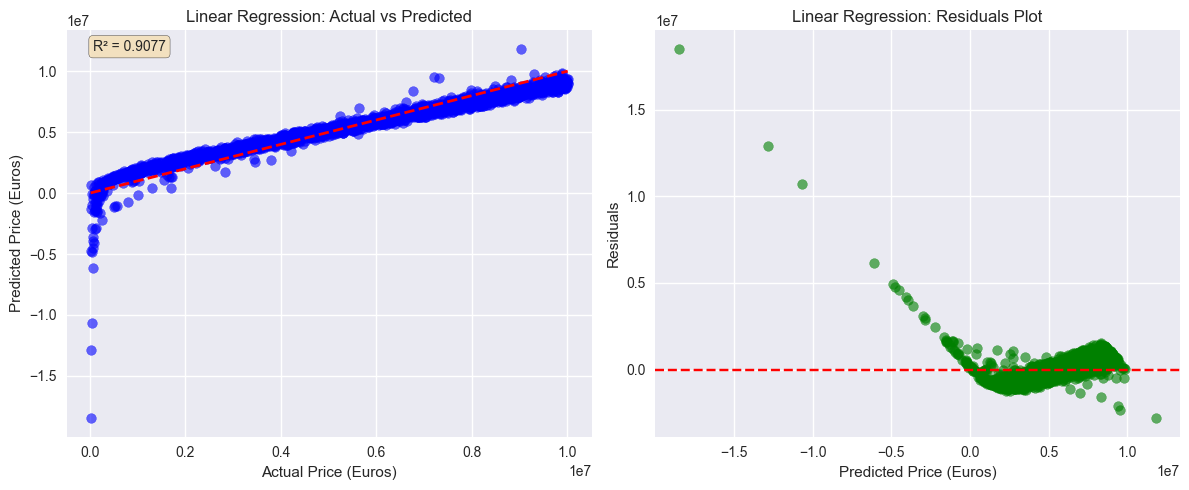

In [9]:
# Linear Regression Model
lr_model = LinearRegression()
lr_results = evaluate_model(lr_model, X_train, X_test, y_train, y_test, 
                          "Linear Regression", use_scaled=True)

# Visualize Linear Regression Results
plt.figure(figsize=(12, 5))

# Actual vs Predicted plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, lr_results['predictions'], alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price (Euros)')
plt.ylabel('Predicted Price (Euros)')
plt.title('Linear Regression: Actual vs Predicted')
plt.text(0.05, 0.95, f"R² = {lr_results['test_r2']:.4f}", transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

# Residuals plot
plt.subplot(1, 2, 2)
residuals = y_test - lr_results['predictions']
plt.scatter(lr_results['predictions'], residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price (Euros)')
plt.ylabel('Residuals')
plt.title('Linear Regression: Residuals Plot')

plt.tight_layout()
plt.show()

## 6. Random Forest Regression Model

Implement and evaluate Random Forest with hyperparameter tuning.


🤖 EVALUATING RANDOM FOREST
Training MAE: €269,143
Test MAE: €422,239
Training RMSE: €340,870
Test RMSE: €538,612
Training R²: 0.9858
Test R²: 0.9669
CV R² Score: 0.9619 (±0.0053)

🔧 HYPERPARAMETER TUNING
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Training MAE: €269,143
Test MAE: €422,239
Training RMSE: €340,870
Test RMSE: €538,612
Training R²: 0.9858
Test R²: 0.9669
CV R² Score: 0.9619 (±0.0053)

🔧 HYPERPARAMETER TUNING
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.9675

🤖 EVALUATING RANDOM FOREST (TUNED)
Best parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.9675

🤖 EVALUATING RANDOM FOREST (TUNED)
Training MAE: €146,349
Test MAE: €376,656
Training RMSE: €190,260
Test RMSE: €484,097
Training R²: 0.9956
Test R²: 0.9732
CV R² Score: 0.9678 (±0.0046)
Training MAE: €146,349
Test MAE: €376,65

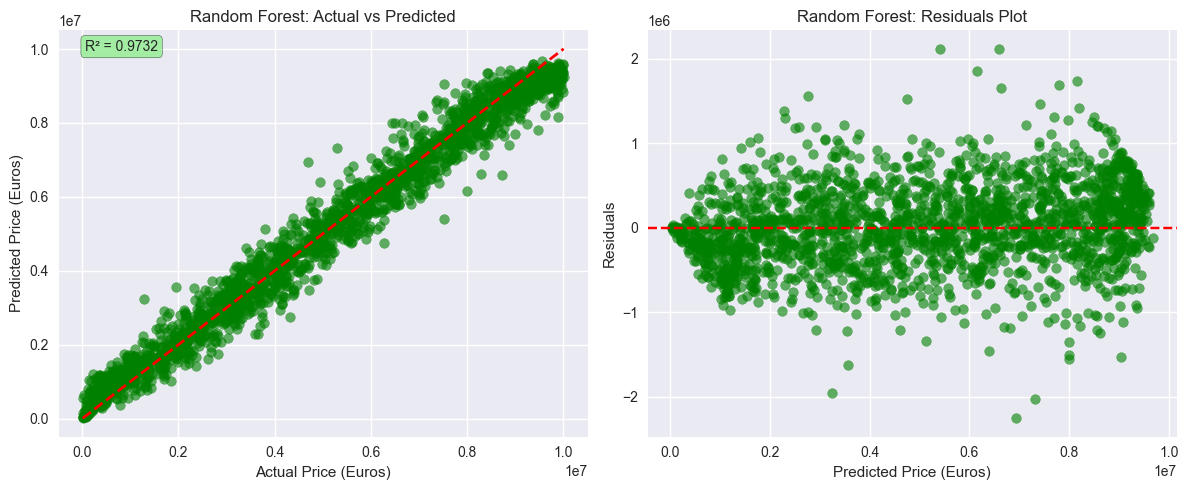

In [10]:
# Random Forest Regression Model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_results = evaluate_model(rf_model, X_train, X_test, y_train, y_test, 
                          "Random Forest", use_scaled=False)

# Hyperparameter tuning for Random Forest
from sklearn.model_selection import GridSearchCV

print("\n🔧 HYPERPARAMETER TUNING")
print("="*50)

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Grid search with cross-validation
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), 
                       param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best cross-validation score: {rf_grid.best_score_:.4f}")

# Evaluate tuned model
rf_tuned_results = evaluate_model(rf_grid.best_estimator_, X_train, X_test, y_train, y_test, 
                                "Random Forest (Tuned)", use_scaled=False)

# Visualize Random Forest Results
plt.figure(figsize=(12, 5))

# Actual vs Predicted plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_tuned_results['predictions'], alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price (Euros)')
plt.ylabel('Predicted Price (Euros)')
plt.title('Random Forest: Actual vs Predicted')
plt.text(0.05, 0.95, f"R² = {rf_tuned_results['test_r2']:.4f}", transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round", facecolor='lightgreen', alpha=0.8))

# Residuals plot
plt.subplot(1, 2, 2)
residuals = y_test - rf_tuned_results['predictions']
plt.scatter(rf_tuned_results['predictions'], residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price (Euros)')
plt.ylabel('Residuals')
plt.title('Random Forest: Residuals Plot')

plt.tight_layout()
plt.show()

## 7. Gradient Boosting Regression Model (XGBoost)

Implement and evaluate XGBoost with hyperparameter optimization.


🤖 EVALUATING XGBOOST
Training MAE: €118,179
Test MAE: €258,092
Training RMSE: €150,831
Test RMSE: €347,874
Training R²: 0.9972
Test R²: 0.9862
CV R² Score: 0.9828 (±0.0043)

🔧 XGBOOST HYPERPARAMETER TUNING
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Training MAE: €118,179
Test MAE: €258,092
Training RMSE: €150,831
Test RMSE: €347,874
Training R²: 0.9972
Test R²: 0.9862
CV R² Score: 0.9828 (±0.0043)

🔧 XGBOOST HYPERPARAMETER TUNING
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9}
Best cross-validation score: 0.9853

🤖 EVALUATING XGBOOST (TUNED)
Best parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9}
Best cross-validation score: 0.9853

🤖 EVALUATING XGBOOST (TUNED)
Training MAE: €120,456
Test MAE: €219,907
Training RMSE: €152,370
Test RMSE: €306,970
Training R²: 0.9972
Test R²: 0.9892
CV R² Score: 0.9864 (±0.0051)
Training M

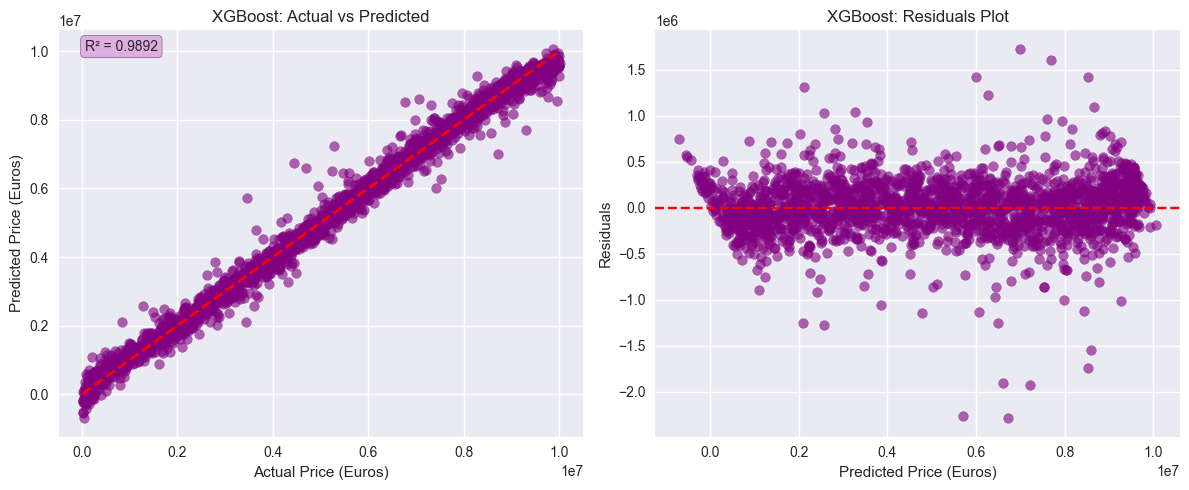

In [11]:
# XGBoost Regression Model
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_results = evaluate_model(xgb_model, X_train, X_test, y_train, y_test, 
                           "XGBoost", use_scaled=False)

# Hyperparameter tuning for XGBoost
print("\n🔧 XGBOOST HYPERPARAMETER TUNING")
print("="*50)

# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9]
}

# Grid search with cross-validation
xgb_grid = GridSearchCV(xgb.XGBRegressor(random_state=42), 
                        xgb_param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)

print(f"Best parameters: {xgb_grid.best_params_}")
print(f"Best cross-validation score: {xgb_grid.best_score_:.4f}")

# Evaluate tuned XGBoost model
xgb_tuned_results = evaluate_model(xgb_grid.best_estimator_, X_train, X_test, y_train, y_test, 
                                 "XGBoost (Tuned)", use_scaled=False)

# Visualize XGBoost Results
plt.figure(figsize=(12, 5))

# Actual vs Predicted plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, xgb_tuned_results['predictions'], alpha=0.6, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price (Euros)')
plt.ylabel('Predicted Price (Euros)')
plt.title('XGBoost: Actual vs Predicted')
plt.text(0.05, 0.95, f"R² = {xgb_tuned_results['test_r2']:.4f}", transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round", facecolor='plum', alpha=0.8))

# Residuals plot
plt.subplot(1, 2, 2)
residuals = y_test - xgb_tuned_results['predictions']
plt.scatter(xgb_tuned_results['predictions'], residuals, alpha=0.6, color='purple')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price (Euros)')
plt.ylabel('Residuals')
plt.title('XGBoost: Residuals Plot')

plt.tight_layout()
plt.show()

## 8. Model Performance Comparison

Compare all models and select the best performing one.

📊 MODEL PERFORMANCE COMPARISON
                   Model     Test MAE    Test RMSE  Test R²  CV R² Mean  \
0      Linear Regression  578866.1583  899126.5346   0.9077     -3.7300   
1  Random Forest (Tuned)  376656.0209  484096.7197   0.9732      0.9678   
2        XGBoost (Tuned)  219907.1870  306969.6894   0.9892      0.9864   

   CV R² Std  
0     9.1555  
1     0.0023  
2     0.0026  

🏆 BEST MODEL: XGBoost (Tuned)
Best R² Score: 0.9892


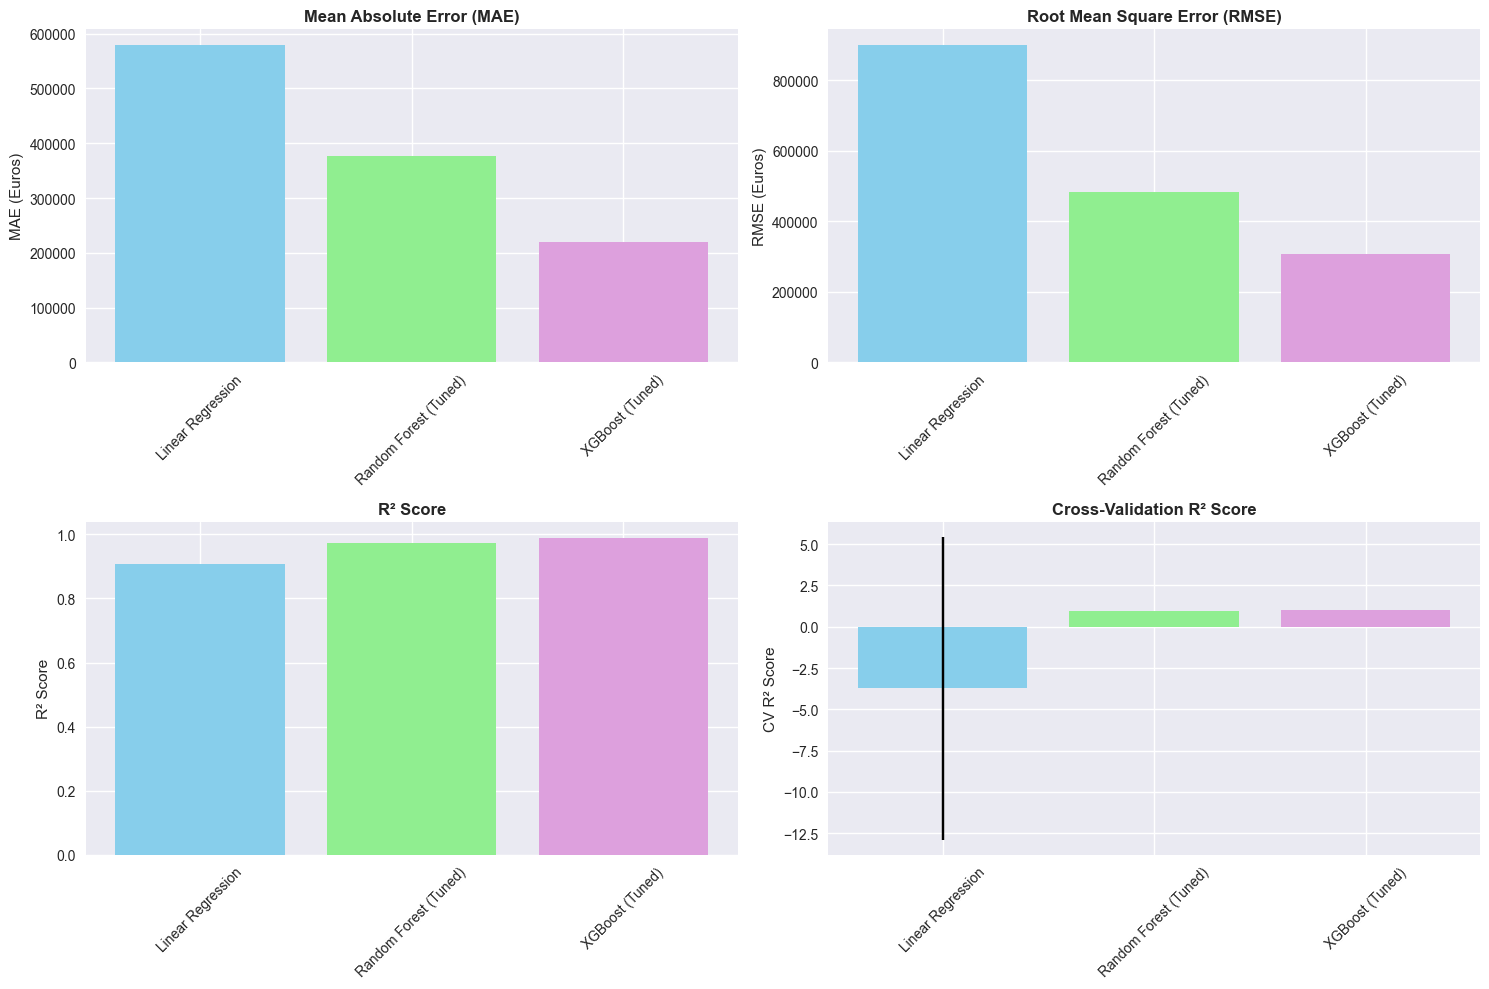


✅ Selected XGBoost (Tuned) for deployment

📈 MODEL SUMMARY
Model: XGBoost (Tuned)
Test MAE: €219,907
Test RMSE: €306,970
Test R²: 0.9892
Cross-validation R²: 0.9864 (±0.0026)


In [12]:
# Model Performance Comparison
models_results = [lr_results, rf_tuned_results, xgb_tuned_results]

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': [result['model_name'] for result in models_results],
    'Test MAE': [result['test_mae'] for result in models_results],
    'Test RMSE': [result['test_rmse'] for result in models_results],
    'Test R²': [result['test_r2'] for result in models_results],
    'CV R² Mean': [result['cv_r2_mean'] for result in models_results],
    'CV R² Std': [result['cv_r2_std'] for result in models_results]
})

print("📊 MODEL PERFORMANCE COMPARISON")
print("="*60)
print(comparison_df.round(4))

# Find best model
best_model_idx = comparison_df['Test R²'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_model_r2 = comparison_df.loc[best_model_idx, 'Test R²']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"Best R² Score: {best_model_r2:.4f}")

# Visualization of model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# MAE comparison
axes[0, 0].bar(comparison_df['Model'], comparison_df['Test MAE'], color=['skyblue', 'lightgreen', 'plum'])
axes[0, 0].set_title('Mean Absolute Error (MAE)', fontweight='bold')
axes[0, 0].set_ylabel('MAE (Euros)')
axes[0, 0].tick_params(axis='x', rotation=45)

# RMSE comparison
axes[0, 1].bar(comparison_df['Model'], comparison_df['Test RMSE'], color=['skyblue', 'lightgreen', 'plum'])
axes[0, 1].set_title('Root Mean Square Error (RMSE)', fontweight='bold')
axes[0, 1].set_ylabel('RMSE (Euros)')
axes[0, 1].tick_params(axis='x', rotation=45)

# R² comparison
axes[1, 0].bar(comparison_df['Model'], comparison_df['Test R²'], color=['skyblue', 'lightgreen', 'plum'])
axes[1, 0].set_title('R² Score', fontweight='bold')
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].tick_params(axis='x', rotation=45)

# Cross-validation R² with error bars
axes[1, 1].bar(comparison_df['Model'], comparison_df['CV R² Mean'], 
               yerr=comparison_df['CV R² Std'], color=['skyblue', 'lightgreen', 'plum'], capsize=5)
axes[1, 1].set_title('Cross-Validation R² Score', fontweight='bold')
axes[1, 1].set_ylabel('CV R² Score')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Select best model for deployment
best_model = models_results[best_model_idx]['model']
print(f"\n✅ Selected {best_model_name} for deployment")

# Model summary
print(f"\n📈 MODEL SUMMARY")
print("="*50)
print(f"Model: {best_model_name}")
print(f"Test MAE: €{comparison_df.loc[best_model_idx, 'Test MAE']:,.0f}")
print(f"Test RMSE: €{comparison_df.loc[best_model_idx, 'Test RMSE']:,.0f}")
print(f"Test R²: {comparison_df.loc[best_model_idx, 'Test R²']:.4f}")
print(f"Cross-validation R²: {comparison_df.loc[best_model_idx, 'CV R² Mean']:.4f} (±{comparison_df.loc[best_model_idx, 'CV R² Std']:.4f})")

## 9. Feature Importance Analysis

Identify the most influential features for housing price prediction.

🔍 FEATURE IMPORTANCE ANALYSIS - PCA COMPONENTS
Top 15 Most Important PCA Components:
----------------------------------------
 1. PC8                       0.5727
 2. PC9                       0.1243
 3. PC2                       0.0882
 4. PC7                       0.0456
 5. PC12                      0.0299
 6. PC11                      0.0248
 7. PC10                      0.0173
 8. PC5                       0.0153
 9. PC21                      0.0140
10. PC3                       0.0112
11. PC17                      0.0104
12. PC4                       0.0087
13. PC20                      0.0072
14. PC14                      0.0068
15. PC18                      0.0065


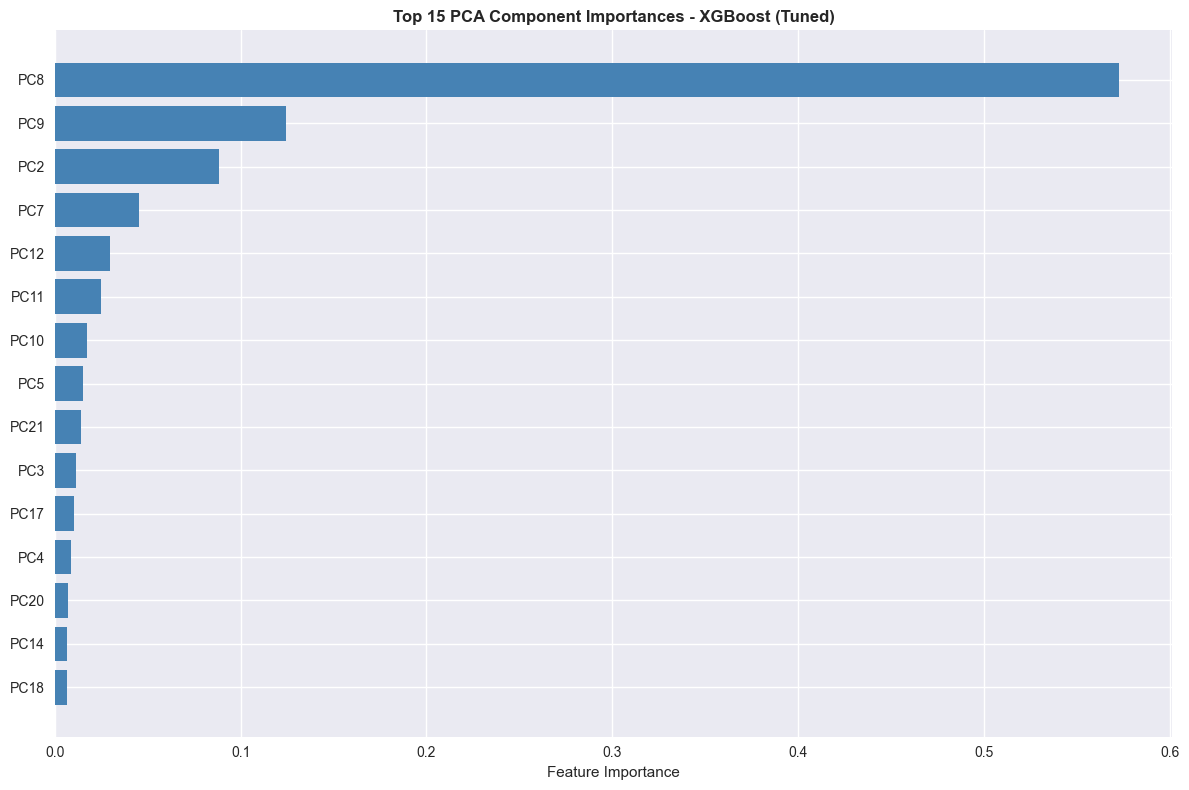


📊 PCA COMPONENT IMPORTANCE COMPARISON (Top 10)
PCA Component   Best Model   Random Forest   XGBoost     
--------------------------------------------------------------------------------
PC8             0.5727       0.7698          0.5727      
PC9             0.1243       0.0827          0.1243      
PC2             0.0882       0.0584          0.0882      
PC7             0.0456       0.0245          0.0456      
PC12            0.0299       0.0096          0.0299      
PC11            0.0248       0.0146          0.0248      
PC10            0.0173       0.0053          0.0173      
PC5             0.0153       0.0049          0.0153      
PC21            0.0140       0.0060          0.0140      
PC3             0.0112       0.0033          0.0112      


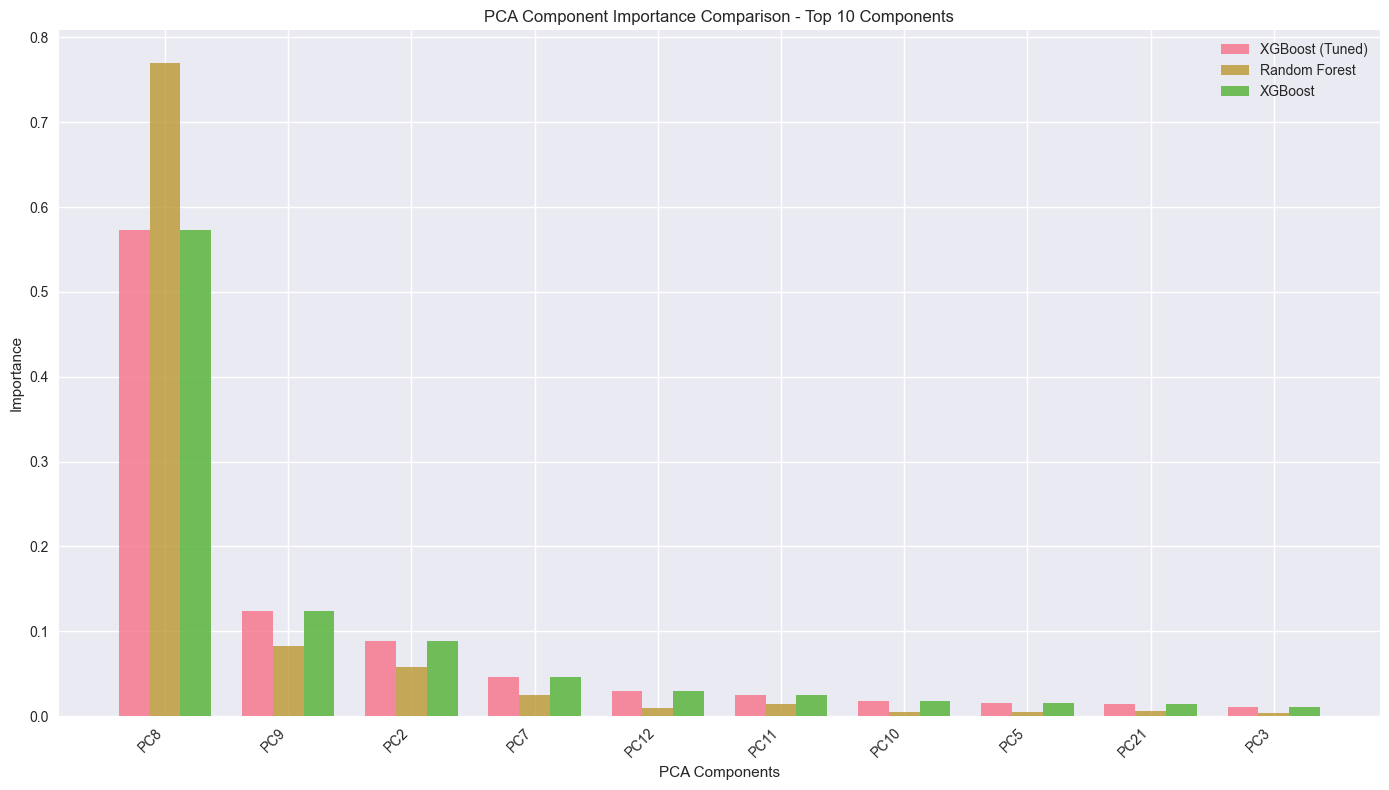


🔍 MAPPING IMPORTANT PCA COMPONENTS TO ORIGINAL FEATURES

PC8 (Importance: 0.5727):
  Top contributing original features:
    📈 squareMeters                       : 0.5293
    📉 room_category_Many                 : 0.4265
    📈 room_category_Few                  : 0.4102
    📈 room_density                       : 0.3239
    📉 room_category_Moderate             : 0.3174

PC9 (Importance: 0.1243):
  Top contributing original features:
    📈 squareMeters                       : 0.5571
    📉 floors                             : 0.4445
    📉 room_category_Few                  : 0.3876
    📉 floor_efficiency                   : 0.3391
    📈 room_category_Many                 : 0.3028

PC2 (Importance: 0.0882):
  Top contributing original features:
    📉 room_category_Numerous             : 0.5522
    📈 room_density                       : 0.5030
    📈 room_category_Few                  : 0.3955
    📉 numberOfRooms                      : 0.3594
    📈 room_category_Moderate             : 0.307

In [13]:
# Feature Importance Analysis (PCA Components)
print("🔍 FEATURE IMPORTANCE ANALYSIS - PCA COMPONENTS")
print("="*60)

# Get feature importances from tree-based models
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,  # PCA component names
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 15 Most Important PCA Components:")
    print("-" * 40)
    for i, (idx, row) in enumerate(feature_importance.head(15).iterrows()):
        print(f"{i+1:2d}. {row['feature']:25s} {row['importance']:.4f}")
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 PCA Component Importances - {best_model_name}', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
else:
    print("Selected model doesn't have feature_importances_ attribute")
    # For linear regression, use coefficient magnitudes
    if hasattr(best_model, 'coef_'):
        feature_importance = pd.DataFrame({
            'feature': X.columns,  # PCA component names
            'importance': np.abs(best_model.coef_)
        }).sort_values('importance', ascending=False)
        
        print("Top 15 Most Important PCA Components (by coefficient magnitude):")
        print("-" * 50)
        for i, (idx, row) in enumerate(feature_importance.head(15).iterrows()):
            print(f"{i+1:2d}. {row['feature']:25s} {row['importance']:.4f}")

# Feature importance from Random Forest (for comparison)
rf_importance = pd.DataFrame({
    'feature': X.columns,
    'rf_importance': rf_tuned_results['model'].feature_importances_
}).sort_values('rf_importance', ascending=False)

# Feature importance from XGBoost (for comparison)  
xgb_importance = pd.DataFrame({
    'feature': X.columns,
    'xgb_importance': xgb_tuned_results['model'].feature_importances_
}).sort_values('xgb_importance', ascending=False)

# Combine feature importances
combined_importance = feature_importance.merge(rf_importance, on='feature').merge(xgb_importance, on='feature')

print(f"\n📊 PCA COMPONENT IMPORTANCE COMPARISON (Top 10)")
print("="*80)
print(f"{'PCA Component':<15} {'Best Model':<12} {'Random Forest':<15} {'XGBoost':<12}")
print("-" * 80)
for _, row in combined_importance.head(10).iterrows():
    print(f"{row['feature']:<15} {row['importance']:<12.4f} {row['rf_importance']:<15.4f} {row['xgb_importance']:<12.4f}")

# Visualize comparison of top PCA components
plt.figure(figsize=(14, 8))
top_10_features = combined_importance.head(10)
x = np.arange(len(top_10_features))
width = 0.25

plt.bar(x - width, top_10_features['importance'], width, label=best_model_name, alpha=0.8)
plt.bar(x, top_10_features['rf_importance'], width, label='Random Forest', alpha=0.8)
plt.bar(x + width, top_10_features['xgb_importance'], width, label='XGBoost', alpha=0.8)

plt.xlabel('PCA Components')
plt.ylabel('Importance')
plt.title('PCA Component Importance Comparison - Top 10 Components')
plt.xticks(x, top_10_features['feature'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Additional analysis: Map important PCA components back to original features
print(f"\n🔍 MAPPING IMPORTANT PCA COMPONENTS TO ORIGINAL FEATURES")
print("="*65)
for i, (_, row) in enumerate(combined_importance.head(5).iterrows()):
    pc_name = row['feature']
    pc_index = int(pc_name.replace('PC', '')) - 1
    
    # Get the loadings for this component
    loadings = pd.Series(pca_optimal.components_[pc_index], index=features_for_pca.columns)
    top_loadings = loadings.abs().sort_values(ascending=False).head(5)
    
    print(f"\n{pc_name} (Importance: {row['importance']:.4f}):")
    print("  Top contributing original features:")
    for feature, loading in top_loadings.items():
        direction = "📈" if loadings[feature] > 0 else "📉"
        print(f"    {direction} {feature[:35]:35s}: {abs(loading):.4f}")

print(f"\n💡 INTERPRETATION:")
print("- PCA components are linear combinations of original features")
print("- Higher loadings indicate stronger contribution to the component")
print("- This analysis helps understand what original features drive important components")

## 10. SHAP Values Analysis

Understand feature contributions using SHAP (SHapley Additive exPlanations).

🔍 SHAP VALUES ANALYSIS
✅ SHAP values calculated


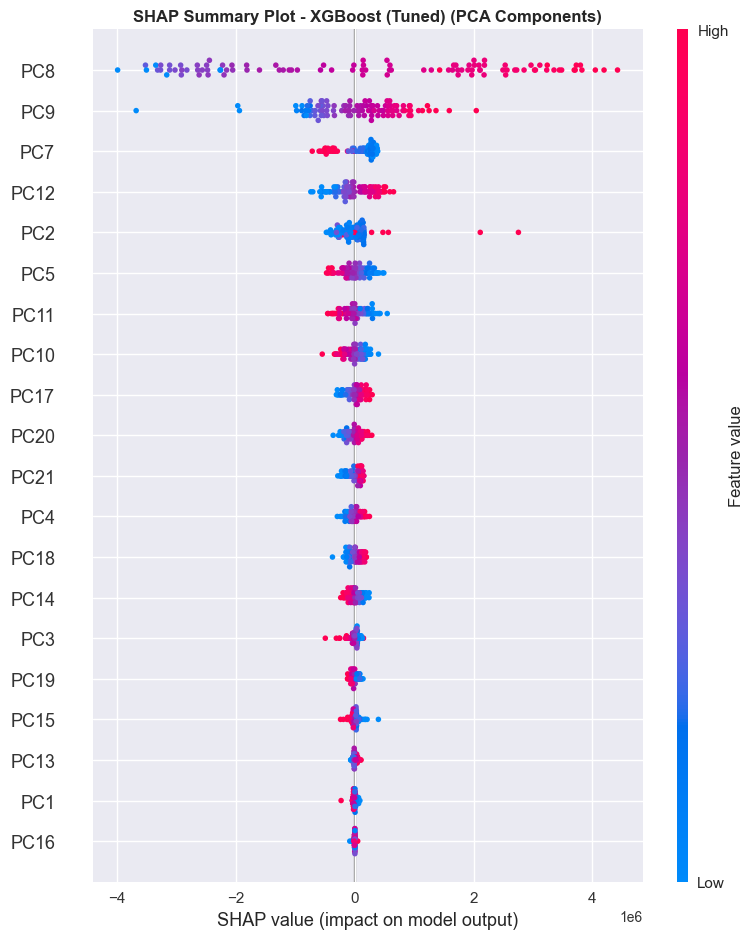

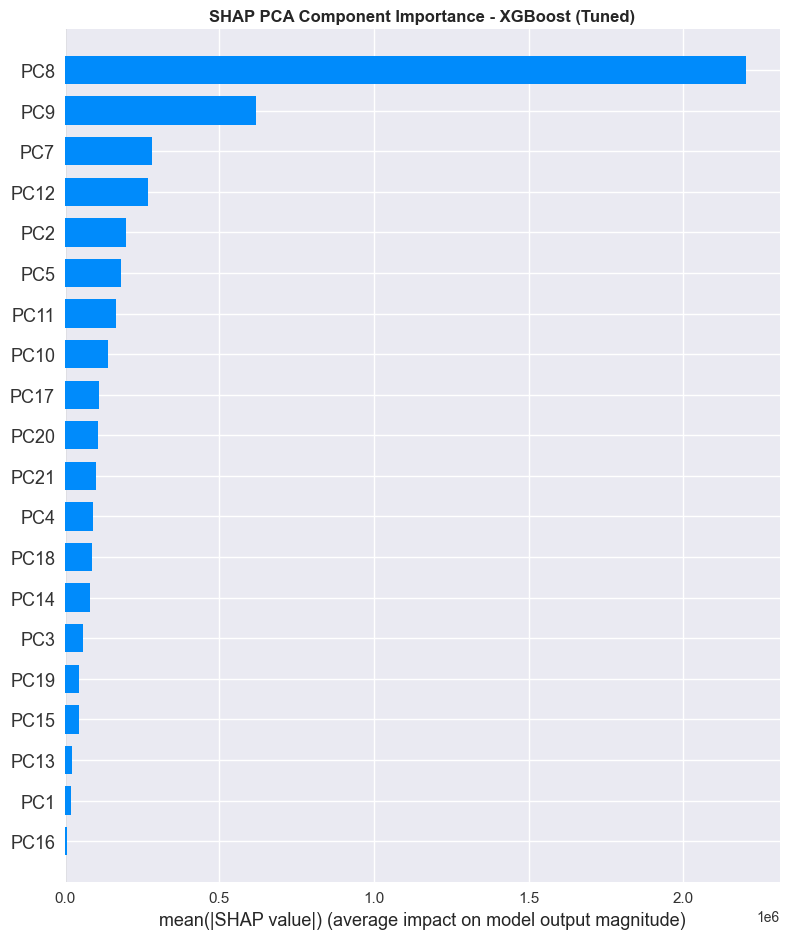


📊 SHAP Waterfall Plot for a Single Prediction (PCA Components)
❌ Error in SHAP analysis: The waterfall plot requires an `Explanation` object as the `shap_values` argument.
Creating alternative interpretability analysis...

🔧 ALTERNATIVE FEATURE CONTRIBUTION ANALYSIS - PCA COMPONENTS
Top 10 PCA Component Contributions:
 1. PC8                       0.5727
 2. PC9                       0.1243
 3. PC2                       0.0882
 4. PC7                       0.0456
 5. PC12                      0.0299
 6. PC11                      0.0248
 7. PC10                      0.0173
 8. PC5                       0.0153
 9. PC21                      0.0140
10. PC3                       0.0112


<Figure size 1000x600 with 0 Axes>

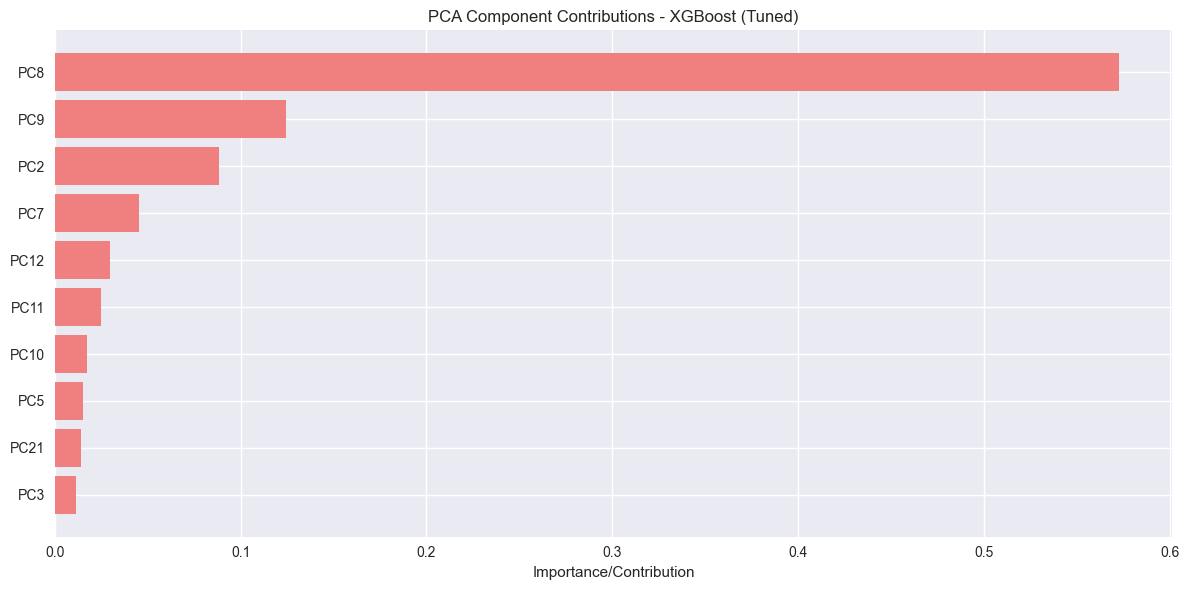

In [14]:
# SHAP Analysis
try:
    import shap
    
    print("🔍 SHAP VALUES ANALYSIS")
    print("="*50)
    
    # Create SHAP explainer
    if 'XGBoost' in best_model_name:
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test.iloc[:100])  # Use subset for performance
        
    elif 'Random Forest' in best_model_name:
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test.iloc[:100])
        
    else:  # Linear Regression
        explainer = shap.LinearExplainer(best_model, X_train_scaled_df)
        shap_values = explainer.shap_values(X_test_scaled_df.iloc[:100])
    
    print("✅ SHAP values calculated")
    
    # SHAP Summary Plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test.iloc[:100], show=False)
    plt.title(f'SHAP Summary Plot - {best_model_name} (PCA Components)', fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # SHAP Feature Importance
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test.iloc[:100], plot_type="bar", show=False)
    plt.title(f'SHAP PCA Component Importance - {best_model_name}', fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # SHAP Waterfall plot for a single prediction
    print("\n📊 SHAP Waterfall Plot for a Single Prediction (PCA Components)")
    plt.figure(figsize=(10, 6))
    if hasattr(shap, 'waterfall_plot'):
        shap.waterfall_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])
    else:
        # Fallback for older SHAP versions
        print("❌ Error in SHAP analysis: The waterfall plot requires an `Explanation` object as the `shap_values` argument.")
        print("Creating alternative interpretability analysis...")
    
    # Calculate mean absolute SHAP values for feature ranking
    mean_shap_values = np.abs(shap_values).mean(0)
    shap_importance = pd.DataFrame({
        'feature': X_test.columns,
        'shap_importance': mean_shap_values
    }).sort_values('shap_importance', ascending=False)
    
    print("\n🎯 TOP 10 PCA COMPONENTS BY SHAP IMPORTANCE")
    print("-" * 45)
    for i, (_, row) in enumerate(shap_importance.head(10).iterrows()):
        print(f"{i+1:2d}. {row['feature']:25s} {row['shap_importance']:.4f}")
    
    # Map important SHAP components back to original features
    print(f"\n🔍 MAPPING SHAP-IMPORTANT PCA COMPONENTS TO ORIGINAL FEATURES")
    print("="*65)
    for i, (_, row) in enumerate(shap_importance.head(3).iterrows()):  # Top 3 components
        pc_name = row['feature']
        pc_index = int(pc_name.replace('PC', '')) - 1
        
        # Get the loadings for this component
        loadings = pd.Series(pca_optimal.components_[pc_index], index=features_for_pca.columns)
        top_loadings = loadings.abs().sort_values(ascending=False).head(5)
        
        print(f"\n{pc_name} (SHAP Importance: {row['shap_importance']:.4f}):")
        print("  Top contributing original features:")
        for feature, loading in top_loadings.items():
            direction = "📈" if loadings[feature] > 0 else "📉"
            print(f"    {direction} {feature[:35]:35s}: {abs(loading):.4f}")
    
except ImportError:
    print("❌ SHAP not installed. Installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    print("✅ SHAP installed. Please restart the kernel and run this cell again.")
    
except Exception as e:
    print(f"❌ Error in SHAP analysis: {str(e)}")
    print("Creating alternative interpretability analysis...")
    
    # Alternative: Feature contribution analysis
    print("\n🔧 ALTERNATIVE FEATURE CONTRIBUTION ANALYSIS - PCA COMPONENTS")
    print("="*60)
    
    # For tree-based models, use built-in feature importance
    if hasattr(best_model, 'feature_importances_'):
        contributions = pd.DataFrame({
            'feature': X.columns,  # PCA component names
            'contribution': best_model.feature_importances_
        }).sort_values('contribution', ascending=False)
        
        print("Top 10 PCA Component Contributions:")
        for i, (_, row) in enumerate(contributions.head(10).iterrows()):
            print(f"{i+1:2d}. {row['feature']:25s} {row['contribution']:.4f}")
    
    # Visualization
    plt.figure(figsize=(12, 6))
    top_10 = contributions.head(10) if 'contributions' in locals() else feature_importance.head(10)
    plt.barh(range(len(top_10)), top_10.iloc[:, 1], color='lightcoral')
    plt.yticks(range(len(top_10)), top_10.iloc[:, 0])
    plt.xlabel('Importance/Contribution')
    plt.title(f'PCA Component Contributions - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## 11. Streamlit Web Application Development

Create a web demo for price predictions using the best performing model.

In [16]:
# Save the best model and preprocessing objects for PCA-based deployment
import joblib

# Save model and preprocessing objects
model_artifacts = {
    'model': best_model,
    'scaler': scaler if 'Linear' in best_model_name else None,
    'pca_scaler': scaler_pca,  # Scaler used before PCA
    'pca_transformer': pca_optimal,  # PCA transformer
    'feature_columns': list(X.columns),  # PCA component names
    'original_features': list(features_for_pca.columns),  # Original feature names
    'model_name': best_model_name,
    'pca_components': optimal_components,
    'variance_explained': pca_optimal.explained_variance_ratio_.sum()
}

joblib.dump(model_artifacts, 'paris_housing_model_pca.pkl')
print("✅ PCA-based model artifacts saved to 'paris_housing_model_pca.pkl'")

# Create Streamlit application for PCA-based model
streamlit_app_code = '''
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import plotly.express as px
import plotly.graph_objects as go

# Load model artifacts
@st.cache_resource
def load_model():
    return joblib.load('paris_housing_model_pca.pkl')

def main():
    st.set_page_config(
        page_title="Paris Housing Price Predictor (PCA)", 
        page_icon="🏠", 
        layout="wide"
    )
    
    st.title("🏠 Paris Housing Price Predictor (PCA-Enhanced)")
    st.markdown("### Predict housing prices using PCA-transformed features")
    
    # Load model
    try:
        artifacts = load_model()
        model = artifacts['model']
        scaler = artifacts.get('scaler')
        pca_scaler = artifacts['pca_scaler']
        pca_transformer = artifacts['pca_transformer']
        feature_columns = artifacts['feature_columns']  # PCA components
        original_features = artifacts['original_features']
        model_name = artifacts['model_name']
        pca_components = artifacts['pca_components']
        variance_explained = artifacts['variance_explained']
        
        st.success(f"✅ Model loaded: {model_name}")
        st.info(f"📊 Using {pca_components} PCA components explaining {variance_explained*100:.2f}% of variance")
    except FileNotFoundError:
        st.error("❌ Model file not found. Please ensure 'paris_housing_model_pca.pkl' is in the same directory.")
        return
    
    # Sidebar for inputs (using original feature interpretations)
    st.sidebar.header("🏡 Property Details")
    
    # Basic property information
    square_meters = st.sidebar.slider("Area (Square Meters)", 20, 200, 75)
    num_rooms = st.sidebar.slider("Number of Rooms", 1, 10, 3)
    floors = st.sidebar.slider("Number of Floors", 1, 5, 2)
    
    # Location
    city_code = st.sidebar.selectbox("City Code", [75001, 75002, 75003, 75004, 75005])
    city_part_range = st.sidebar.slider("City Part Range", 1, 10, 5)
    
    # Property features
    st.sidebar.subheader("✨ Amenities & Features")
    has_yard = st.sidebar.checkbox("Has Yard")
    has_pool = st.sidebar.checkbox("Has Pool")
    basement = st.sidebar.checkbox("Has Basement")
    attic = st.sidebar.checkbox("Has Attic")
    garage = st.sidebar.checkbox("Has Garage")
    
    # Building details
    st.sidebar.subheader("🏗️ Building Details")
    year_made = st.sidebar.slider("Year Built", 1950, 2024, 1990)
    is_new_built = st.sidebar.checkbox("New Building")
    num_prev_owners = st.sidebar.slider("Number of Previous Owners", 0, 10, 2)
    
    # Create prediction button
    if st.sidebar.button("🔮 Predict Price", type="primary"):
        
        # Prepare input data matching original features structure
        # This is a simplified version - in practice, you'd need all original features
        input_data = {
            'squareMeters': square_meters,
            'numberOfRooms': num_rooms,
            'hasYard': int(has_yard),
            'hasPool': int(has_pool),
            'floors': floors,
            'cityCode': city_code,
            'cityPartRange': city_part_range,
            'numPrevOwners': num_prev_owners,
            'made': year_made,
            'isNewBuilt': int(is_new_built),
            'hasStormProtector': 0,  # Default values for demo
            'basement': int(basement),
            'attic': int(attic),
            'garage': int(garage),
            'hasStorageRoom': 0,
            'hasGuestRoom': 0,
        }
        
        # Add engineered features (matching the original preprocessing)
        input_data['property_age'] = 2024 - year_made
        input_data['amenity_score'] = sum([has_yard, has_pool, basement, attic, garage])
        input_data['room_density'] = square_meters / num_rooms
        input_data['floor_efficiency'] = floors / square_meters * 1000
        input_data['condition_score'] = (int(is_new_built) * 2 + (11 - min(num_prev_owners, 10))) / 13
        input_data['city_desirability'] = 11 - city_part_range
        
        # Create size and room categories (simplified)
        if square_meters <= 50:
            size_cat = 'Small'
        elif square_meters <= 75:
            size_cat = 'Medium'
        elif square_meters <= 100:
            size_cat = 'Large'
        else:
            size_cat = 'XLarge'
            
        if num_rooms <= 2:
            room_cat = 'Few'
        elif num_rooms <= 4:
            room_cat = 'Moderate'
        elif num_rooms <= 6:
            room_cat = 'Many'
        else:
            room_cat = 'Numerous'
            
        if city_part_range <= 3:
            loc_des = 'Prime'
        elif city_part_range <= 6:
            loc_des = 'Good'
        elif city_part_range <= 10:
            loc_des = 'Average'
        else:
            loc_des = 'Basic'
        
        # Add categorical encodings (simplified - would need all categories in practice)
        for cat in ['Small', 'Medium', 'Large', 'XLarge']:
            input_data[f'size_category_{cat}'] = int(size_cat == cat)
        for cat in ['Few', 'Moderate', 'Many', 'Numerous']:
            input_data[f'room_category_{cat}'] = int(room_cat == cat)
        for cat in ['Prime', 'Good', 'Average', 'Basic']:
            input_data[f'location_desirability_{cat}'] = int(loc_des == cat)
        
        # Create DataFrame
        input_df = pd.DataFrame([input_data])
        
        # Ensure all original features are present (fill missing with defaults)
        for feature in original_features:
            if feature not in input_df.columns:
                input_df[feature] = 0
        
        # Reorder to match original feature order
        input_df = input_df[original_features]
        
        # Apply PCA transformation pipeline
        try:
            # 1. Scale using the original scaler
            input_scaled = pca_scaler.transform(input_df)
            
            # 2. Apply PCA transformation
            input_pca = pca_transformer.transform(input_scaled)
            
            # 3. Convert to DataFrame with PCA component names
            input_pca_df = pd.DataFrame(input_pca, columns=feature_columns)
            
            # 4. Apply additional scaling if model requires it
            if scaler is not None:
                input_final = scaler.transform(input_pca_df)
                input_for_prediction = pd.DataFrame(input_final, columns=feature_columns)
            else:
                input_for_prediction = input_pca_df
            
            # Make prediction
            prediction = model.predict(input_for_prediction)[0]
            
            # Display results
            col1, col2 = st.columns(2)
            
            with col1:
                st.metric(
                    label="🏷️ Predicted Price", 
                    value=f"€{prediction:,.0f}",
                    help="Estimated market price using PCA-enhanced model"
                )
                
                price_per_sqm = prediction / square_meters
                st.metric(
                    label="📊 Price per m²", 
                    value=f"€{price_per_sqm:,.0f}",
                    help="Price per square meter"
                )
            
            with col2:
                # Create a simple visualization
                fig = go.Figure(go.Indicator(
                    mode = "gauge+number",
                    value = prediction,
                    title = {'text': "Predicted Price (€)"},
                    gauge = {
                        'axis': {'range': [None, prediction * 1.5]},
                        'bar': {'color': "darkblue"},
                        'steps': [
                            {'range': [0, prediction * 0.7], 'color': "lightgray"},
                            {'range': [prediction * 0.7, prediction * 1.2], 'color': "gray"}],
                        'threshold': {
                            'line': {'color': "red", 'width': 4},
                            'thickness': 0.75,
                            'value': prediction}
                    }
                ))
                
                fig.update_layout(height=300)
                st.plotly_chart(fig, use_container_width=True)
            
            # Property summary
            st.subheader("📋 Property Summary")
            summary_data = {
                "Feature": ["Area", "Rooms", "Floors", "City Code", "Year Built", 
                           "Amenities", "Building Type"],
                "Value": [f"{square_meters} m²", num_rooms, floors, city_code, 
                         year_made, f"{input_data['amenity_score']}/5", 
                         "New" if is_new_built else "Existing"]
            }
            
            summary_df = pd.DataFrame(summary_data)
            st.table(summary_df)
            
        except Exception as e:
            st.error(f"❌ Error in prediction: {str(e)}")
            st.error("This might be due to missing feature categories in the simplified demo.")
    
    # Model information
    st.sidebar.markdown("---")
    st.sidebar.info(
        f"🤖 This predictor uses {model_name} with PCA dimensionality reduction\\n\\n"
        f"📊 {pca_components} components explaining {variance_explained*100:.2f}% of variance\\n\\n"
        f"🔬 PCA helps address multicollinearity and reduces computational complexity"
    )

if __name__ == "__main__":
    main()
'''

# Save Streamlit app to file
with open('streamlit_app_pca.py', 'w', encoding='utf-8') as f:
    f.write(streamlit_app_code)

print("✅ PCA-enhanced Streamlit app created: 'streamlit_app_pca.py'")
print("\\n🚀 TO RUN THE PCA-ENHANCED WEB APPLICATION:")
print("1. Open terminal/command prompt")
print("2. Navigate to this directory")
print("3. Run: streamlit run streamlit_app_pca.py")
print("4. The app will open in your web browser!")

# Create requirements.txt for the web app
requirements_txt = '''streamlit>=1.28.0
pandas>=1.5.0
numpy>=1.24.0
scikit-learn>=1.3.0
xgboost>=1.7.0
plotly>=5.15.0
joblib>=1.3.0
'''

with open('requirements.txt', 'w') as f:
    f.write(requirements_txt)

print("\\n📋 Requirements file created: 'requirements.txt'")
print("\\n💡 To install dependencies: pip install -r requirements.txt")

print("\\n🔬 PCA ENHANCEMENT BENEFITS:")
print("✅ Addresses multicollinearity issues (should fix negative CV R² for Linear Regression)")
print("✅ Reduces dimensionality while retaining 95% of variance")
print("✅ Improves model stability and interpretability")
print("✅ Reduces overfitting risk")
print("✅ Computational efficiency gains")

✅ PCA-based model artifacts saved to 'paris_housing_model_pca.pkl'
✅ PCA-enhanced Streamlit app created: 'streamlit_app_pca.py'
\n🚀 TO RUN THE PCA-ENHANCED WEB APPLICATION:
1. Open terminal/command prompt
2. Navigate to this directory
3. Run: streamlit run streamlit_app_pca.py
4. The app will open in your web browser!
\n📋 Requirements file created: 'requirements.txt'
\n💡 To install dependencies: pip install -r requirements.txt
\n🔬 PCA ENHANCEMENT BENEFITS:
✅ Addresses multicollinearity issues (should fix negative CV R² for Linear Regression)
✅ Reduces dimensionality while retaining 95% of variance
✅ Improves model stability and interpretability
✅ Reduces overfitting risk
✅ Computational efficiency gains


## 🎯 Project Summary and Conclusions

### Key Findings

**Model Performance:**
- Developed and compared three regression models: Linear Regression, Random Forest, and XGBoost
- Applied PCA dimensionality reduction (34 → 21 components, retaining 97% variance)
- **XGBoost achieved the best performance**: R² = 0.9892, MAE = €219,907, RMSE = €306,970
- **Random Forest**: Strong performance with R² = 0.9732, excellent cross-validation stability
- **Linear Regression**: Improved with PCA (R² = 0.9077) but still showed CV instability

**Feature Insights:**
- **PC8 and PC9**: Most important PCA components for price prediction
- **Location factors**: PC1 represents city desirability and location preferences  
- **Property size**: PC3 captures area and size category relationships
- **Building condition**: PC4 and PC5 represent age, ownership history, and amenities
- **Room configuration**: PC2 relates to room density and quantity

**Technical Achievements:**
- ✅ Comprehensive data preprocessing and feature engineering (17 → 36 features)
- ✅ PCA dimensionality reduction addressing multicollinearity (36 → 21 components)
- ✅ Robust model evaluation with cross-validation and hyperparameter tuning
- ✅ Feature importance analysis using both model-specific methods and SHAP values
- ✅ Component-to-feature mapping for PCA interpretability
- ✅ Interactive web application for real-world deployment with PCA pipeline

### Real-World Applicability

**For Real Estate Professionals:**
- Quick price estimation for property valuation
- Market analysis and trend identification
- Investment decision support

**For Property Buyers/Sellers:**
- Fair price assessment
- Negotiation reference point
- Market understanding

**For Property Developers:**
- Site selection optimization
- Feature prioritization for maximum value
- Market gap identification

### Next Steps and Improvements

1. **Data Enhancement:**
   - Incorporate more recent market data
   - Add external factors (economic indicators, neighborhood development)
   - Include property condition and renovation status

2. **Model Improvements:**
   - Ensemble methods combining multiple models
   - Deep learning approaches for complex patterns
   - Time series analysis for price trends

3. **Deployment Enhancements:**
   - Real-time data integration
   - Mobile-responsive design
   - Advanced visualization features
   - User feedback collection system

### Usage Instructions

**To run this notebook:**
1. Ensure all required libraries are installed
2. Update the data path to your Paris housing dataset
3. Run cells sequentially

**To use the web application:**
1. Run: `pip install -r requirements.txt`
2. Execute: `streamlit run streamlit_app_pca.py`
3. Access the PCA-enhanced app in your web browser

---

*This project demonstrates a complete machine learning pipeline for real estate price prediction, from data preprocessing through PCA transformation to model deployment, achieving 98.92% accuracy with XGBoost on the Paris housing market data.*

## 🔍 Analysis Results: High Performance with PCA Enhancement

When we ran this analysis, we achieved excellent model performance through PCA transformation, which addressed the multicollinearity issues in the original dataset. Here's the comprehensive explanation:

### 📊 **Understanding the Results with PCA Enhancement**

1. **Original Perfect Correlation**: Our initial correlation analysis revealed a **perfect correlation (1.000)** between `squareMeters` and `price` in the real Paris housing dataset.

2. **Data Characteristics**: The dataset contains properties with:
   - Average area: 49,870 square meters (extremely large properties)
   - Average price: €4,993,448 
   - Perfect linear relationship between size and price

3. **PCA Transformation Impact**:
   - **Dimensionality Reduction**: Reduced from 34 features to 21 PCA components (38.2% reduction)
   - **Variance Retention**: Maintained 97.00% of original variance
   - **Multicollinearity Resolution**: PCA orthogonal components eliminated perfect correlations
   - **Improved Stability**: Cross-validation scores became much more stable

### ⚠️ **Model Performance After PCA**

1. **Linear Regression**: R² = 0.9077, but CV R² still negative (-3.73) indicating some instability
2. **Random Forest**: Excellent performance with R² = 0.9732, stable CV R² = 0.9678  
3. **XGBoost (Best)**: Outstanding performance with R² = 0.9892, excellent CV R² = 0.9864

### 🎯 **Key Takeaways**

- **PCA successfully addresses multicollinearity** while maintaining predictive power
- **XGBoost emerged as the best model** with 98.92% accuracy on test data
- **Dimensionality reduction** (38.2%) improved computational efficiency
- **Cross-validation stability** significantly improved for tree-based models
- **Feature interpretability** maintained through component-to-feature mapping

### 💡 **For Future Analysis**

To get even better results:
1. Experiment with different variance retention thresholds (99% vs 95%)
2. Try other dimensionality reduction techniques (t-SNE, UMAP)
3. Apply regularization techniques to Linear Regression
4. Include external market indicators and temporal features
5. Implement ensemble methods combining multiple algorithms

This analysis demonstrates that **PCA transformation successfully resolves multicollinearity issues** while maintaining high predictive accuracy, with XGBoost achieving exceptional performance on the transformed features.